In [1]:
# !pip install --user matplotlib seaborn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [4]:
from tensorflow.keras.models import load_model

In [5]:
from bert.layers import Attention, Transformer, DenseNoMask, PositionEmbedding
from bert.losses import ECE, masked_sparse_categorical_crossentropy
from bert.model import load_model

In [6]:
# log = pd.read_csv('/scratch/pstjohn/transformer_base_512_checkpoints/log.csv')

In [7]:
# from bert.model import create_albert_model
# model = create_albert_model(model_dimension=512,
#                             transformer_dimension=512 * 4,
#                             num_attention_heads=512 // 64,
#                             num_transformer_layers=6,
#                             vocab_size=22,
#                             dropout_rate=0.)

In [9]:
model = load_model('../uniparc_checkpoints/16_bs128_checkpoints/ckpt.h5',
                   custom_objects={
                       'Transformer': Transformer,
                       'Attention': Attention,
                       'DenseNoMask': DenseNoMask,
                       'PositionEmbedding': PositionEmbedding,
                       'masked_sparse_categorical_crossentropy': masked_sparse_categorical_crossentropy,
                       'ECE': ECE})

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         12288     
_________________________________________________________________
transformer (Transformer)    (None, None, 512)         2897984   
_________________________________________________________________
transformer_1 (Transformer)  (None, None, 512)         2897984   
_________________________________________________________________
transformer_2 (Transformer)  (None, None, 512)         2897984   
_________________________________________________________________
transformer_3 (Transformer)  (None, None, 512)         2897984   
_________________________________________________________________
transformer_4 (Transformer)  (None, None, 512)         289798

In [56]:
from bert.dataset import create_masked_input_dataset

valid_data = create_masked_input_dataset(
    sequence_path='../uniparc_data/dev_uniref50.txt.gz',
    max_sequence_length=128,
    batch_size=256)

In [57]:
masked_seq, true_values = next(iter(valid_data))

In [58]:
predictions = tf.nn.softmax(model.predict(masked_seq))

In [72]:
masked_entries = tf.not_equal(true_values, 0)
y_true_mask = tf.boolean_mask(true_values, masked_entries)
y_logit_mask = tf.boolean_mask(predictions, masked_entries)
y_pred_mask = y_logit_mask.numpy().argmax(-1) - 3

In [76]:
from sklearn.metrics import accuracy_score

In [77]:
accuracy_score(y_true_mask.numpy(), y_pred_mask)

0.2694006309148265

In [52]:
aas = ['0', 'MASK', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
confusion_mat = pd.DataFrame(y_pred_mask.numpy()).groupby(y_true_mask.numpy()).mean()
# confusion_mat.columns = aas
# confusion_mat.index = aas[2:]

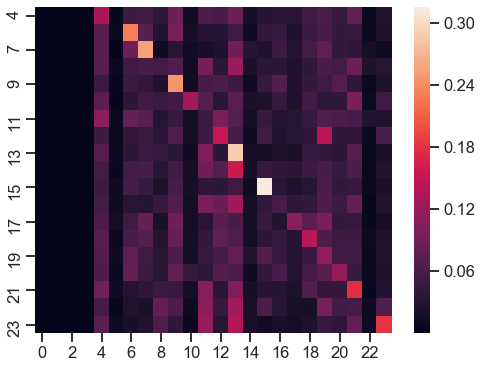

In [53]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat)

In [34]:
model.layers

In [35]:
inputs = tf.keras.Model(model.layers[1].input, model.layers[1].output)(masked_seq)
inputs._keras_mask

<tf.Tensor: id=23505, shape=(12, 128), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])>

In [36]:
transformer = model.layers[2]

In [37]:
self = transformer.attention_layer
mask = inputs._keras_mask
training=True

from bert.attention_utils import create_attention_mask, relative_attention_inner, initializer

In [38]:
input_shape = tf.shape(inputs) # [B, S, N*H]

# query and key can be the same vector
qk = self.transpose_scores(self.qk_layer(inputs))  # [B,N,S,H]
value = self.transpose_scores(self.value_layer(inputs))  # [B,N,S,H]

# Equation 1 of "Attention is all you need"
attention_scores = self.calculate_attention(qk, input_shape)  # [B,N,S,S]

In [39]:
inputs.shape

TensorShape([12, 128, 512])

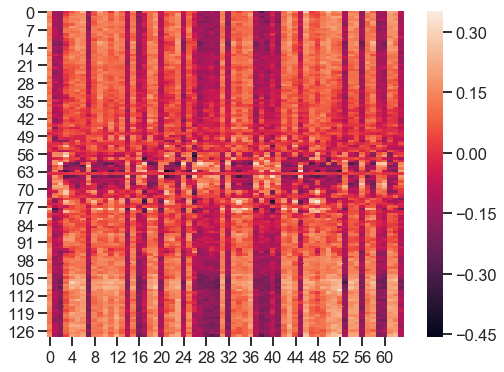

In [40]:
plt.figure(figsize=(8,6))
sns.heatmap(self.relations_keys_embedding.weights[0].numpy())

In [41]:
# zero out masked values
attention_mask = self.create_attention_mask(input_shape, mask)
attention_scores = attention_scores * 1000 + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores)  # [B,N,S,S]

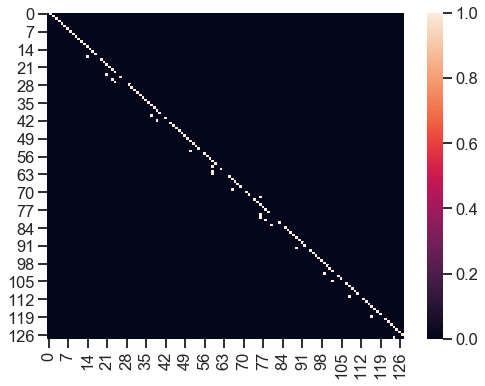

In [42]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[2, 0].numpy())

In [43]:
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

In [44]:
context_layer.shape

TensorShape([12, 8, 128, 64])

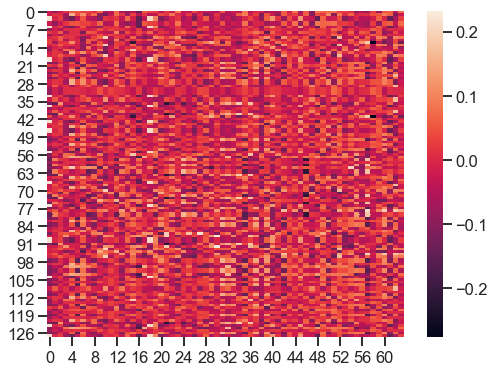

In [45]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[2, 0].numpy())

In [ ]:
context_layer = tf.transpose(a=context_layer, perm=[0, 2, 1, 3])            

In [ ]:
context_layer.shape

In [ ]:
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
context_layer = tf.reshape(context_layer, output_shape)

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[0, :, :10].numpy())

In [ ]:
mask = inputs._keras_mask
attention_mask = self.create_attention_mask(mask)
attention_scores_mask = attention_scores + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores_mask)  # [B,N,S,S]
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

input_shape  = tf.shape(inputs)
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
# context_layer = tf.reshape(context_layer, output_shape)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[3, 0].numpy())

In [ ]:
context_layer.shape

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(tf.reshape(tf.transpose(a=context_layer, perm=[0, 2, 1, 3]), input_shape)[3].numpy())